In [11]:
!pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_RNN.git # colab 사용시

# [Recurrent Neural Networks - 회귀] 

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

### 1. 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import time
import copy

import random
import matplotlib.pyplot as plt     

# regression 평가지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore') 

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. 데이터 불러오기

In [2]:
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

- https://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html
- 나스닥 100에 속한 81개 기업의 주가와 나스닥 100지수 값으로 구성
- 2016년 7월 26일부터 2016년 12월 22일까지 수집 (105일)
- 누락된 데이터에 대해 정제된 데이터
- X: 81개 종목의 종가
- y: NASDAQ 100 지수

In [3]:
# data = pd.read_csv('./data/reg_nasdaq100.csv')
data = pd.read_csv('/content/2023_LG_ES_RNN/data/reg_nasdaq100.csv')

#### 2.1 Data Exploratory Data Analysis

In [4]:
data.head() # 상위 5개

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


In [5]:
data.tail() # 하위 5개

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
40555,48.503,115.880,104.19,73.2895,102.29,74.690,67.39,121.1264,32.9200,146.3911,...,73.8100,34.8100,24.7550,72.1400,84.33,70.230,32.04,59.9200,38.5300,4921.811
40556,48.515,115.875,104.18,73.2900,102.31,74.675,67.43,121.2000,32.9300,146.3951,...,73.8100,34.7950,24.7597,72.0928,84.34,70.220,32.03,59.9290,38.5100,4921.580
40557,48.530,115.875,104.15,73.2850,102.32,74.680,67.40,121.3500,32.9064,146.3700,...,73.8001,34.7901,24.7571,72.0600,84.35,70.165,32.03,59.9345,38.5084,4921.884
40558,48.560,115.920,104.19,73.3000,102.31,74.750,67.35,121.3000,32.9200,146.3400,...,73.8101,34.8200,24.7500,72.0950,84.32,70.210,32.04,59.9400,38.5050,4922.949
40559,48.560,115.910,104.17,73.2900,102.28,74.740,67.33,121.2400,32.9100,146.3100,...,73.8000,34.8300,24.7500,72.1000,84.32,70.200,32.01,59.9500,38.5100,4922.942


In [6]:
data.shape # 데이터 차원 확인

(40560, 82)

In [7]:
data.describe() # 데이터 통계값 확인

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
count,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,...,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,39.800869,111.045244,103.896265,65.368279,90.880519,69.562835,58.263494,126.006463,29.476487,160.666420,...,70.377165,38.579280,28.345028,88.504968,81.953751,55.411002,29.935632,52.911550,41.587485,4813.996404
std,4.650207,4.153281,3.788460,4.042551,4.124842,5.701877,6.735718,6.240876,1.764568,12.560062,...,1.721643,2.929651,2.311799,8.608155,2.260631,7.119791,1.406414,2.304339,1.670313,63.285327
min,33.040000,96.435000,95.460000,59.230000,85.500000,56.798900,47.800000,109.190000,25.690000,135.045000,...,66.390000,33.990000,24.180000,71.540000,76.508300,43.110000,27.685000,48.530000,38.010000,4649.127000
25%,36.220000,108.070000,100.750000,62.880000,87.610000,66.940000,52.385000,121.460000,28.350000,146.800000,...,69.380000,36.505000,26.090000,80.447500,80.370000,47.400000,28.570000,51.170000,40.390000,4774.126750
50%,38.455000,110.945900,103.970000,63.850000,89.680000,70.630000,55.020000,125.750000,29.565000,166.667500,...,70.005000,37.560000,28.485000,88.710000,81.670000,55.635400,30.280100,53.055000,41.870000,4810.097000
75%,43.090500,114.260000,107.570000,65.757150,92.550000,72.630000,66.040000,131.041250,30.270000,171.790000,...,71.060000,40.790000,30.677025,96.020000,83.270000,59.535000,30.890000,53.950000,42.845000,4857.886000
max,50.589900,118.628500,111.053500,74.860000,102.810000,82.900000,70.869600,144.980000,33.620000,176.610000,...,75.250000,46.235000,31.680000,103.730000,88.000000,71.880000,34.535000,60.930000,44.900000,4962.391000


In [8]:
x = data.drop(['NDX'], axis=1)
y = data[['NDX']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('x_train examples')
x_train.head()

x_train shape is (28392, 81)
y_train shape is (28392, 1)
-----------------------------------
x_test shape is (12168, 81)
y_test shape is (12168, 1)
-----------------------------------
x_train examples


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,227.6500,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,227.0967,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,226.6300,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,227.5300,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,227.1250,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320


In [9]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

columns_list = list(x_train.columns)
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print('x_train examples')
pd.DataFrame(x_train, columns = columns_list).head()

x_train examples


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,0.377892,0.016446,0.150063,0.277457,0.944656,0.083294,0.442140,0.361793,0.185741,0.740166,...,0.823137,0.702265,0.916632,0.887439,0.719682,0.568587,0.482152,0.914599,0.012559,0.000000
1,0.371594,0.020501,0.150063,0.343931,0.945754,0.083897,0.447342,0.326930,0.195122,0.742574,...,0.812146,0.695793,0.898382,0.891832,0.683234,0.589075,0.481620,0.936496,0.032967,0.018868
2,0.368175,0.023205,0.135313,0.397399,0.955153,0.084701,0.439973,0.342938,0.191745,0.749068,...,0.802876,0.794498,0.898797,0.896247,0.702419,0.587904,0.488013,0.923358,0.072214,0.020319
3,0.366324,0.024106,0.134030,0.413295,0.956107,0.085505,0.440406,0.334756,0.196998,0.748298,...,0.820753,0.796117,0.899212,0.896247,0.687873,0.608977,0.489611,0.916058,0.065934,0.026851
4,0.381491,0.023656,0.145573,0.384393,0.957061,0.086309,0.451243,0.345607,0.193246,0.744497,...,0.812709,0.755663,0.901701,0.889625,0.682737,0.610148,0.489611,0.946715,0.056515,0.044993


#### 2.2 Data Windowing

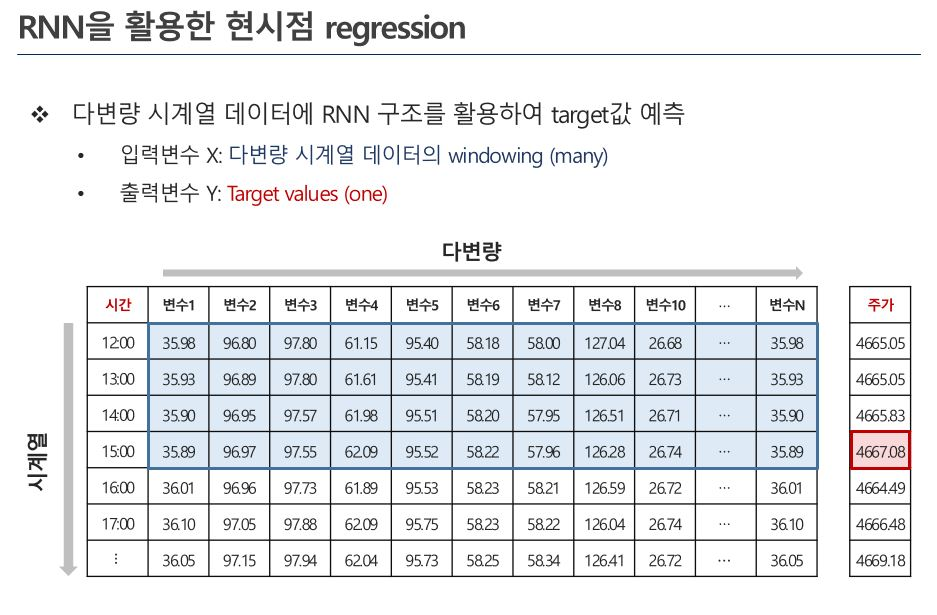

In [12]:
# Image('./image/image8.JPG')
Image('/content/2023_LG_ES_RNN/image/image8.JPG')

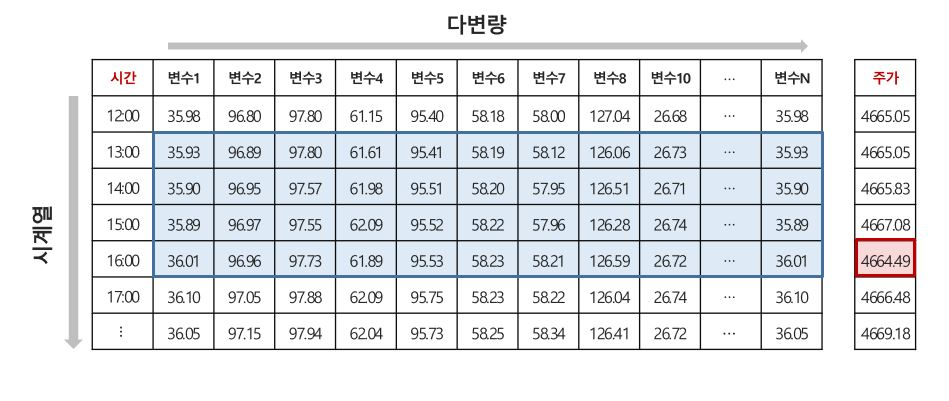

In [13]:
# Image('./image/image9.JPG')
Image('/content/2023_LG_ES_RNN/image/image9.JPG')

In [14]:
def windowing_process(x, y, window_size, shift_size, last = True):
    try:
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
    except:
        pass
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1])  # 마지막 index의 값을 사용하는 경우
        
        else:
            y_window.append(np.mean(y[start_idx:start_idx + window_size]))  # window 내 값들의 평균
    
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [15]:
x_train, y_train = windowing_process(x_train, y_train, 5, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 5, 1, True)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (28388, 5, 81)
y_train shape is (28388,)
-----------------------------------
x_test shape is (12164, 5, 81)
y_test shape is (12164,)


In [16]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (22710, 5, 81)
y_train shape is (22710,)
-----------------------------------
x_train shape is (5678, 5, 81)
y_train shape is (5678,)
-----------------------------------
x_test shape is (12164, 5, 81)
y_test shape is (12164,)


### 3. RNN Modeling

#### 3.1 Define the Model Structure

In [17]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # recurrent layer 설정
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
     
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, 1)  # self.num_classes = 1로 설정된 구조
        # self.fc = nn.Linear(self.num_directions * hidden_size, self.num_classes) --> classification
        
    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # RNN으로부터 output 도출
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = self.fc(out[:, -1, :])
        return out

#### 3.2 Define The Training Testing Strategy

In [18]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, device='cuda'): 
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.device = device
        self.input_size = input_size

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 
        
        train_loss_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_loss = 999999999 # MSE는 작을수록 좋은 metric이므로, 초기 높은 값에서 갱신

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        outputs = outputs.reshape(-1)
                        
                        loss = criterion(outputs, targets)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_total += targets.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                                    
                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f}'.format(phase, epoch_loss))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)

        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val MSE: {:4f}'.format(best_loss))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():

            preds = []
            y_true = []
            for inputs, targets in test_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # forward
                # input을 model에 넣어 output을 도출
                pred = model(inputs)
                
                preds.extend(pred.detach().cpu().numpy())
                y_true.extend(targets.detach().cpu().numpy())

            preds = torch.tensor(preds).reshape(-1)
            y_true = torch.tensor(y_true)
            
            mse = nn.MSELoss()(preds, y_true).item()
            preds = preds.detach().cpu().numpy()
        return preds, mse

### 4. Model Training

#### 4.1 Hyperparameter Setting

- batch_size: 학습 및 검증에 사용할 배치의 크기
- input_size: 변수 개수
- hidden_size: 모델의 hidden dimension
- num_layers: 모델의 layer 개수
- bidirectional: 모델의 양방향성 여부
- num_epochs: 학습할 epoch 횟수
- device: 사용할 자원 선정
- best_model_path: 모델 파라미터 저장 위치

In [20]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
best_model_path = '/content/2023_LG_ES_RNN/ckpt/rnn_reg.pt'

#### 4.2 Construct Data Loaders and Model

In [21]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [22]:
model = RNN_model(input_size, hidden_size, num_layers, bidirectional, device)
model = model.to(device)

#### 4.3 Model Training and Save Weights(Parameters)

In [23]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/200
train Loss: 0.0310
val Loss: 0.0251

Epoch 10/200
train Loss: 0.0002
val Loss: 0.0497

Epoch 20/200
train Loss: 0.0001
val Loss: 0.0400

Epoch 30/200
train Loss: 0.0000
val Loss: 0.0337

Epoch 40/200
train Loss: 0.0000
val Loss: 0.0258

Epoch 50/200
train Loss: 0.0000
val Loss: 0.0194

Epoch 60/200
train Loss: 0.0000
val Loss: 0.0123

Epoch 70/200
train Loss: 0.0000
val Loss: 0.0102

Epoch 80/200
train Loss: 0.0000
val Loss: 0.0082

Epoch 90/200
train Loss: 0.0000
val Loss: 0.0064

Epoch 100/200
train Loss: 0.0000
val Loss: 0.0050

Epoch 110/200
train Loss: 0.0000
val Loss: 0.0044

Epoch 120/200
train Loss: 0.0000
val Loss: 0.0035

Epoch 130/200
train Loss: 0.0000
val Loss: 0.0037

Epoch 140/200
train Loss: 0.0000
val Loss: 0.0032

Epoch 150/200
train Loss: 0.0000
val Loss: 0.0030

Epoch 160/200
train Loss: 0.0000
val Loss: 0.0025

Epoch 170/200
train Loss: 0.0000
val Loss: 0.0025

Epoch 180/200
train Loss: 0.0000
val Loss: 0.0025

Epoch 190/200
train Loss: 0.0000
val Loss

In [28]:
torch.save(best_model.state_dict(), best_model_path)

### 5. Model Validation

#### 5.1 Loss History Visualization

Text(0, 0.5, 'loss')

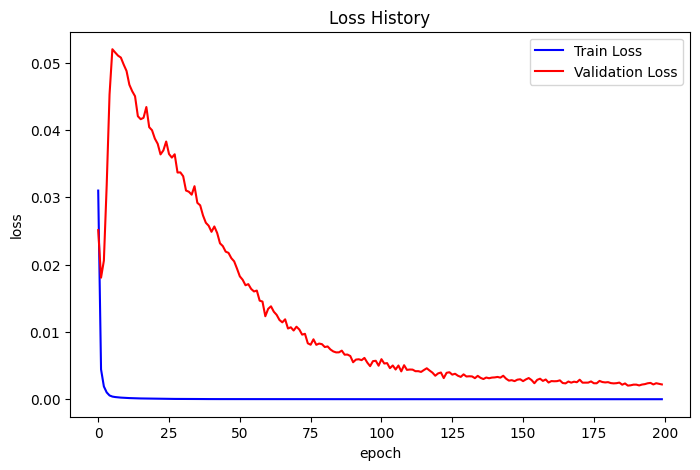

In [29]:
plt.figure(figsize=(8,5))
plt.title('Loss History')
plt.plot(range(num_epochs), train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

#### 5.2 Load Model Weights(Parameters)

In [30]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [31]:
y_pred, mse = trainer.test(model, test_loader)
y_pred_inverse = y_scaler.inverse_transform(pd.DataFrame(y_pred))
y_test_inverse = y_scaler.inverse_transform(pd.DataFrame(y_test))
y_train_inverse = y_scaler.inverse_transform(pd.DataFrame(y_train))
y_valid_inverse = y_scaler.inverse_transform(pd.DataFrame(y_valid))

print('y prediction (raw)')
print(y_pred)
print('-'*35)
print('y prediction (inverse minmax scaler)')
print(y_pred_inverse)

y prediction (raw)
[0.19640785 0.1958465  0.1949602  ... 0.8457285  0.84843665 0.8471514 ]
-----------------------------------
y prediction (inverse minmax scaler)
[[4700.654 ]
 [4700.507 ]
 [4700.274 ]
 ...
 [4871.001 ]
 [4871.7114]
 [4871.3745]]


#####  R squared (결정계수 $({r})^{2}$) <br>
$\frac{SSR}{SST} = 1- \frac{SSR}{SST}%$

##### Mean Absolute Error (평균 절대 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$

###### Mean Squared Error (평균 제곱 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$   

######  Root Mean Squared Error (제곱근 평균 제곱 오차) <br>
$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$

##### Mean Absolute Percentage Error (평균 절대비 오차) <br>
$\sum_{i=1}^{n} |\frac{y_{i} - \hat{y}_{i}}{\hat{y}_{i}}| *100\%$

In [32]:
def regression_report(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
      
    print('The regression reports are as follows:')
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(rmse,4))
    print('MAPE: ', round(mape,4))
    return r2, mae, mse, rmse, mape

r2, mae, mse, rmse, mape = regression_report (y_test_inverse.flatten(), y_pred_inverse.flatten())

The regression reports are as follows:
r2:  0.9192
MAE:  14.4441
MSE:  458.0527
RMSE:  21.4022
MAPE:  0.295


In [33]:
y_train_concat = np.concatenate([y_train_inverse, y_valid_inverse], axis=0)
y_train = np.concatenate([y_train_concat, np.array([np.nan]*len(y_test_inverse)).reshape(len(y_test_inverse), -1)], axis=0)
y_test = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_test_inverse], axis=0)
y_pred = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_pred_inverse], axis=0)

y_train = pd.DataFrame(y_train, columns = ['Train set'])
y_test = pd.DataFrame(y_test, columns = ['Test set'])
y_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

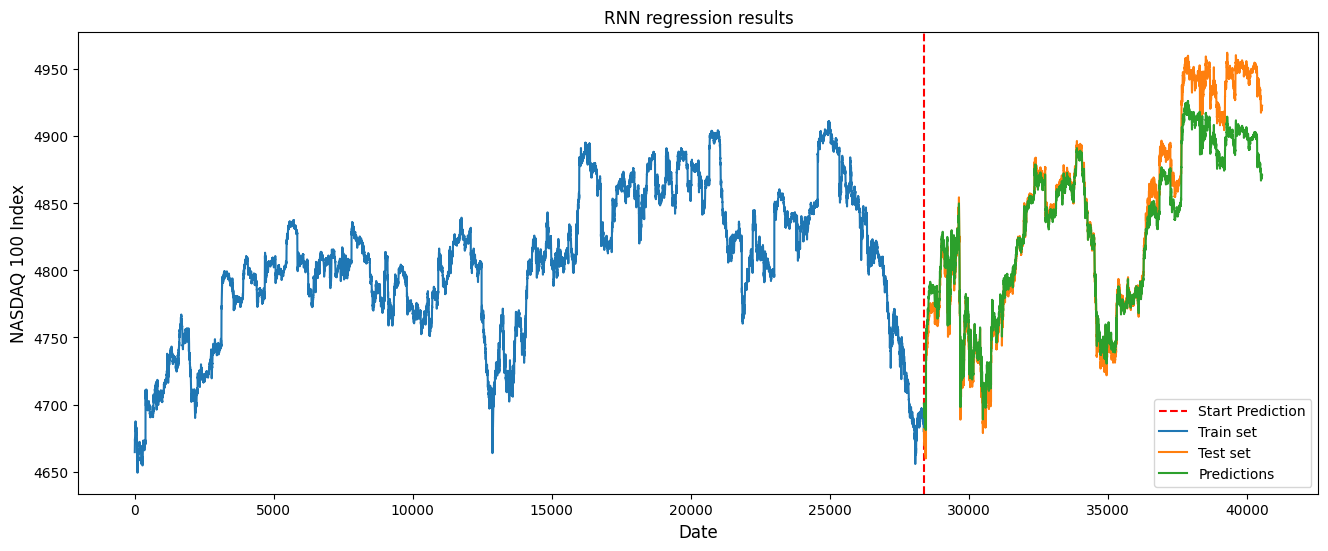

In [34]:
plt.figure(figsize=(16,6))
plt.title('RNN regression results', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NASDAQ 100 Index', fontsize=12)
plt.axvline(x=len(y_train_concat), color='r', label='Start Prediction', ls='--')
plt.plot(y_train['Train set'])
plt.plot(y_test['Test set'])
plt.plot(y_pred['Predictions'])
plt.legend(['Start Prediction', 'Train set', 'Test set', 'Predictions'], loc='lower right')
plt.show()

# EOD